In [21]:
import os
import gc
from glob import glob
import sys
import math
import time
import random
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, List
from scipy.stats import entropy
from scipy.signal import butter, lfilter, freqz
from contextlib import contextmanager
from collections import defaultdict, Counter
# from kaggle_kl_div import score
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, log_loss
from tqdm import tqdm
from functools import partial
# import cv2
# from PIL import Image
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR, CosineAnnealingLR, CosineAnnealingWarmRestarts
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import v2
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
# import albumentations as A
# from albumentations import (Compose, Normalize, Resize, RandomResizedCrop, HorizontalFlip, VerticalFlip, ShiftScaleRotate, Transpose)
# from albumentations.pytorch import ToTensorV2
# from albumentations import ImageOnlyTransform
# import timm
import warnings 
warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from matplotlib import pyplot as plt
import joblib

In [80]:
class CFG:
    version = 2
    criterion = nn.KLDivLoss(reduction="batchmean")
    num_workers = 0
    model_name = 'resnet1d_gru'
    optimizer='AdamW'
    epochs = 10
    lr = 1e-3
    batch_size = 64
    eval_every = 1000
    target_cols = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
    num_class = 6
    n_fold = 5
    # trn_fold = [0, 1, 2, 3, 4]
    trn_fold = [0, 1]
    PATH = './hms-harmful-brain-activity-classification/'
    eeg_features = ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
    feature_to_index = {x:i for i, x in enumerate(eeg_features)}
    map_features = [
        ("Fp1", "T3"),
        ("T3", "O1"),
        ("Fp1", "C3"),
        ("C3", "O1"),
        ("Fp2", "C4"),
        ("C4", "O2"),
        ("Fp2", "T4"),
        ("T4", "O2"),
    ]
    num_features = len(map_features)
    in_channels = 8



       eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0  1628180742           0                       0.0          353733   
1  1628180742           1                       6.0          353733   
2  1628180742           2                       8.0          353733   
3  1628180742           3                      18.0          353733   
4  1628180742           4                      24.0          353733   

   spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                   0                               0.0   127492639   
1                   1                               6.0  3887563113   
2                   2                               8.0  1142670488   
3                   3                              18.0  2718991173   
4                   4                              24.0  3080632009   

   patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  lrda_vote  \
0       42516          Seizure             3         0         0   

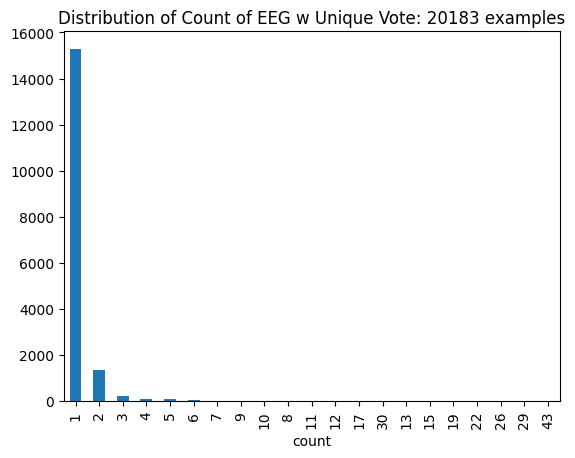

In [7]:
train = pd.read_csv(CFG.PATH + '/train.csv')
TARGETS = train.columns[-6:]
print(train.head())
print('Train shape:', train.shape )
print('Targets', list(TARGETS))

train['total_evaluators'] = train[TARGETS].sum(axis=1)

train_uniq = train.drop_duplicates(subset=['eeg_id'] + list(TARGETS))

print(f'There are {train.patient_id.nunique()} patients in the training data.')
print(f'There are {train.eeg_id.nunique()} EEG IDs in the training data.')
print(f'There are {train_uniq.shape[0]} unique eeg_id + votes in the training data.')

train_uniq.eeg_id.value_counts().value_counts().plot(kind='bar', title=f'Distribution of Count of EEG w Unique Vote: '
                                                                    f'{train_uniq.shape[0]} examples');
train = train_uniq.copy()
y_data = train[TARGETS].values +  1/6 # Regularization value
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

train['target'] = train['expert_consensus']
train = train.reset_index(drop=True)

del train_uniq
_ = gc.collect()

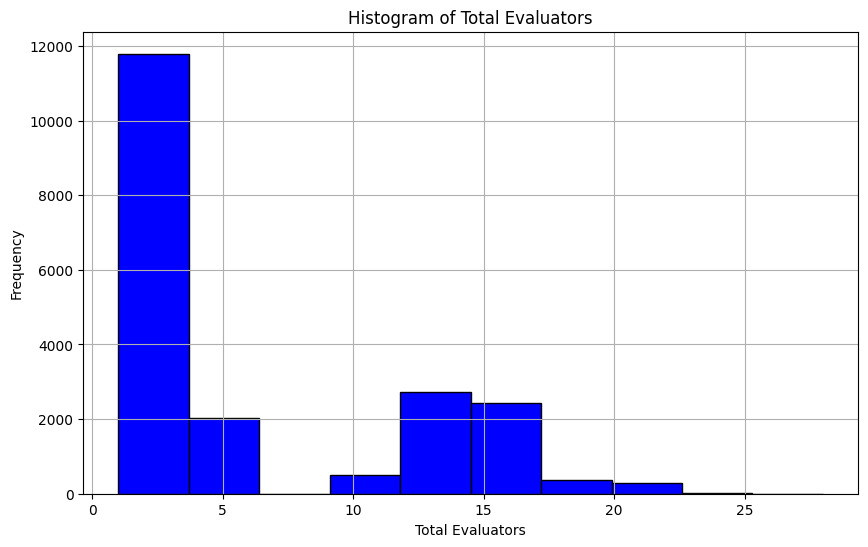

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(train['total_evaluators'], bins=10, color='blue', edgecolor='black')
plt.title('Histogram of Total Evaluators')
plt.xlabel('Total Evaluators')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [9]:
all_eegs = np.load('./resnet/eegs.npy',allow_pickle=True).item()
eeg_ids = train.eeg_id.unique()

In [10]:
gkf = GroupKFold(n_splits=CFG.n_fold)

train["fold"] = -1

for fold_id, (_, val_idx) in enumerate(
    gkf.split(train, y=train["target"], groups=train["patient_id"])
):
    train.loc[val_idx, "fold"] = fold_id

In [11]:
from scipy.signal import butter, lfilter

def quantize_data(data, classes):
    mu_x = mu_law_encoding(data, classes)
    return mu_x#quantized

def mu_law_encoding(data, mu):
    mu_x = np.sign(data) * np.log(1 + mu * np.abs(data)) / np.log(mu + 1)
    return mu_x

def mu_law_expansion(data, mu):
    s = np.sign(data) * (np.exp(np.abs(data) * np.log(mu + 1)) - 1) / mu
    return s

def butter_lowpass_filter(data, cutoff_freq=20, sampling_rate=200, order=4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data

class EEGDataset(Dataset):
    def __init__(
        self, df: pd.DataFrame, config, mode: str = 'train',
        eegs: Dict[int, np.ndarray] = all_eegs, downsample: int = None
    ): 
        self.df = df
        self.config = config
        self.mode = mode
        self.eegs = eegs
        self.downsample = downsample
        
    def __len__(self):
        """
        Length of dataset.
        """
        return len(self.df)
        
    def __getitem__(self, index):
        """
        Get one item.
        """
        X, y_prob = self.__data_generation(index)
        if self.downsample is not None:
            X = X[::self.downsample,:]
        output = {
            "eeg": torch.tensor(X, dtype=torch.float32),
            "labels": torch.tensor(y_prob, dtype=torch.float32)
        }
        return output
                        
    def __data_generation(self, index):
        row = self.df.iloc[index]
        X = np.zeros((10_000, CFG.num_features), dtype='float32')
        y = np.zeros(CFG.num_class, dtype='float32')
        data = self.eegs[row.eeg_id]

        # === Feature engineering ===
        feature_to_index = CFG.feature_to_index
        # X[:,0] = data[:,feature_to_index['Fp1']] - data[:,feature_to_index['T3']]
        # X[:,1] = data[:,feature_to_index['T3']] - data[:,feature_to_index['O1']]

        # X[:,2] = data[:,feature_to_index['Fp1']] - data[:,feature_to_index['C3']]
        # X[:,3] = data[:,feature_to_index['C3']] - data[:,feature_to_index['O1']]

        # X[:,4] = data[:,feature_to_index['Fp2']] - data[:,feature_to_index['C4']]
        # X[:,5] = data[:,feature_to_index['C4']] - data[:,feature_to_index['O2']]

        # X[:,6] = data[:,feature_to_index['Fp2']] - data[:,feature_to_index['T4']]
        # X[:,7] = data[:,feature_to_index['T4']] - data[:,feature_to_index['O2']]

        for i, p in enumerate(CFG.map_features):
            X[:, i] = data[:, feature_to_index[p[0]]] - data[:, feature_to_index[p[1]]]

        # === Standarize ===
        X = np.clip(X,-1024, 1024)
        X = np.nan_to_num(X, nan=0) / 32.0

        # === Butter Low-pass Filter ===
        X = butter_lowpass_filter(X)
        if self.mode != 'test':
            y_prob = row[self.config.target_cols].values.astype(np.float32)
        return X, y_prob

In [12]:
train_dataset = EEGDataset(train, CFG, mode="train")
train_loader = DataLoader(
    train_dataset,
    batch_size=CFG.batch_size,
    shuffle=True,
    num_workers=CFG.num_workers, pin_memory=True, drop_last=True
)
output = train_dataset[0]
X, y = output["eeg"], output["labels"]
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: torch.Size([10000, 8])
y shape: torch.Size([6])


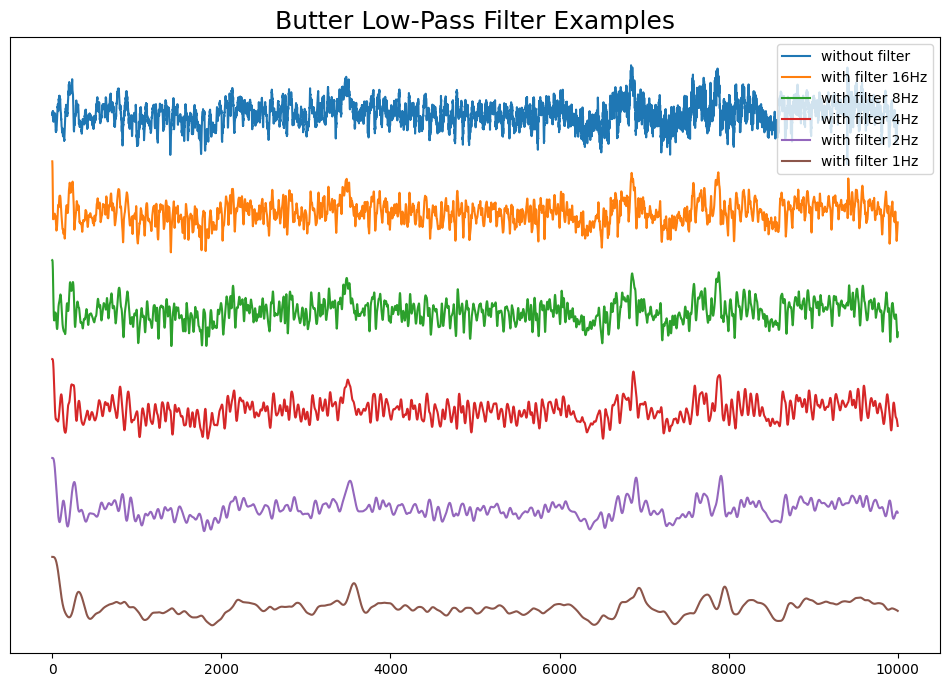

In [13]:
frequencies = [1,2,4,8,16][::-1] # frequencies in Hz
x = [all_eegs[eeg_ids[0]][:,0]] # select one EEG feature

for frequency in frequencies:
    x.append(butter_lowpass_filter(x[0], cutoff_freq=frequency))

plt.figure(figsize=(12,8))
plt.plot(range(10_000), x[0], label='without filter')
for k in range(1,len(x)):
    plt.plot(range(10_000),x[k]-k*(x[0].max()-x[0].min()), label=f'with filter {frequencies[k-1]}Hz')

plt.legend()
plt.yticks([])
plt.title('Butter Low-Pass Filter Examples',size=18)
plt.show()

Hi
tensor([[[ 1.0568e-03, -7.1008e-04, -1.3463e-03,  ...,  1.9720e-03,
          -1.4473e-03, -2.2298e-03],
         [ 1.0923e-02, -6.5386e-03, -7.2727e-03,  ...,  1.4029e-02,
          -5.6863e-03, -1.6782e-02],
         [ 4.9635e-02, -2.7883e-02, -1.6558e-02,  ...,  4.7851e-02,
          -3.1083e-03, -6.0851e-02],
         ...,
         [ 3.2699e-01, -6.6676e-02, -4.0675e-01,  ...,  4.3695e-01,
           3.0020e-01, -8.7607e-01],
         [ 3.3106e-01, -6.7792e-02, -3.9384e-01,  ...,  4.3665e-01,
           2.9399e-01, -8.7911e-01],
         [ 3.5072e-01, -8.8613e-02, -3.7549e-01,  ...,  4.4066e-01,
           2.8137e-01, -8.8616e-01]],

        [[ 9.0170e-03,  3.0763e-02,  3.0825e-02,  ...,  1.0993e-02,
           1.1132e-02,  7.3059e-03],
         [ 7.0047e-02,  2.2969e-01,  2.3145e-01,  ...,  8.2658e-02,
           9.1847e-02,  5.3847e-02],
         [ 2.6116e-01,  8.2615e-01,  8.3726e-01,  ...,  3.0003e-01,
           3.6312e-01,  1.9459e-01],
         ...,
         [ 7.9613e+00,

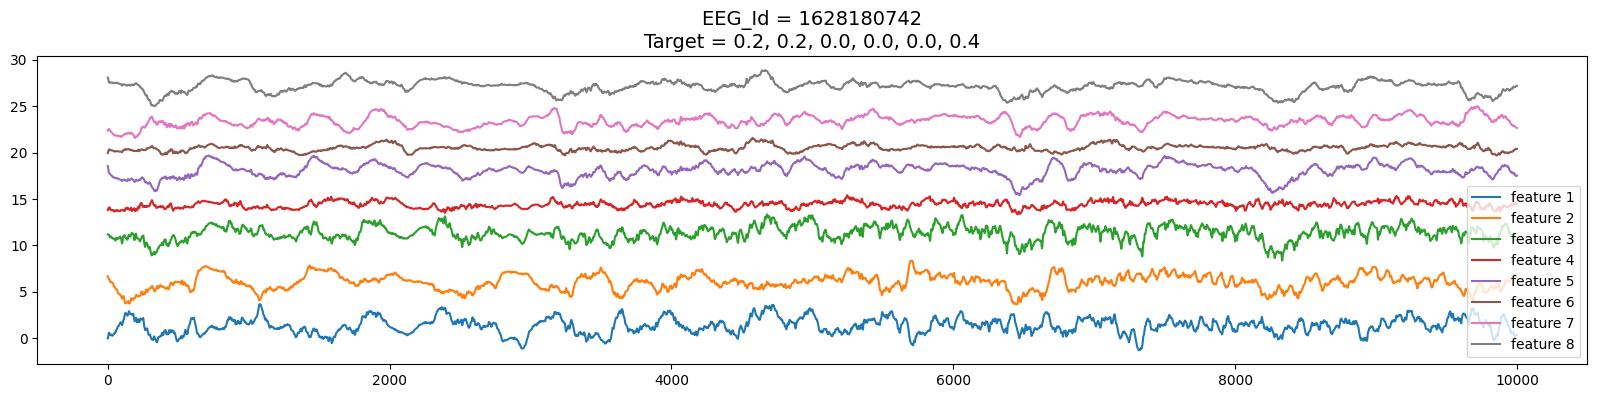

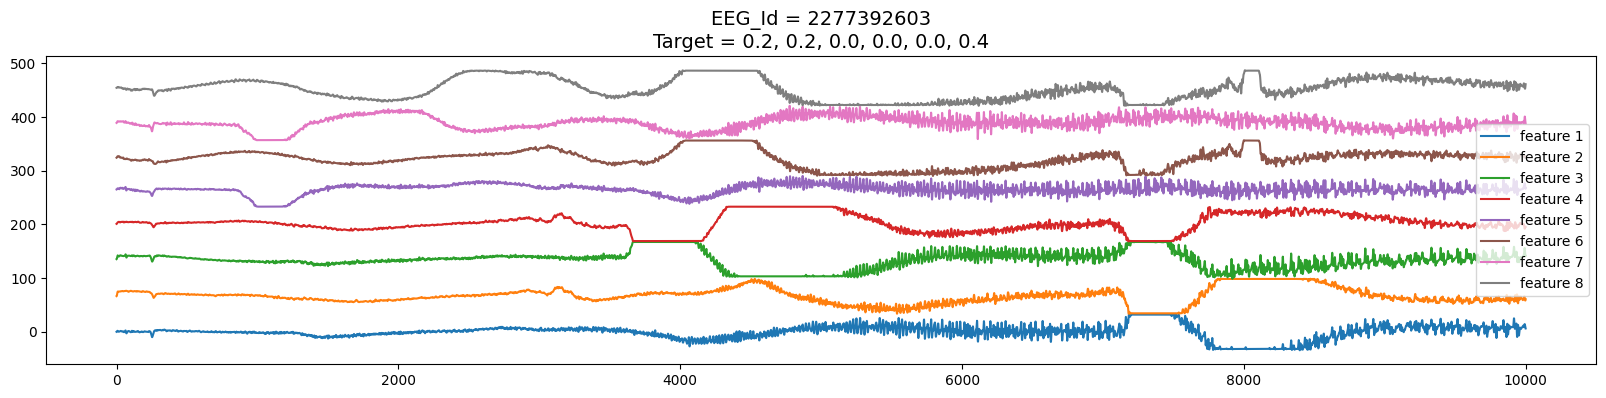

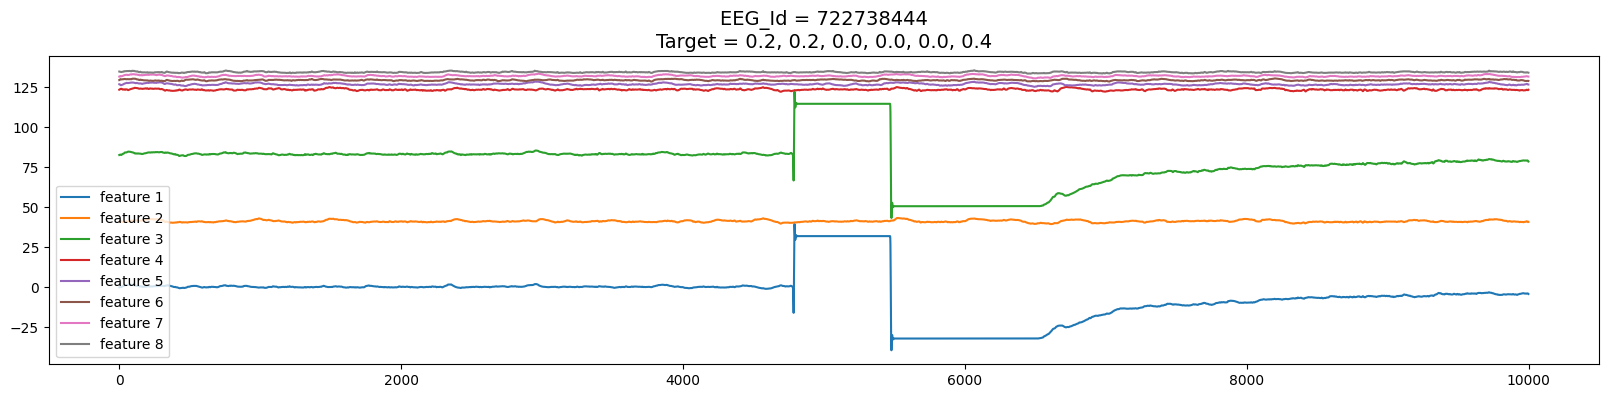

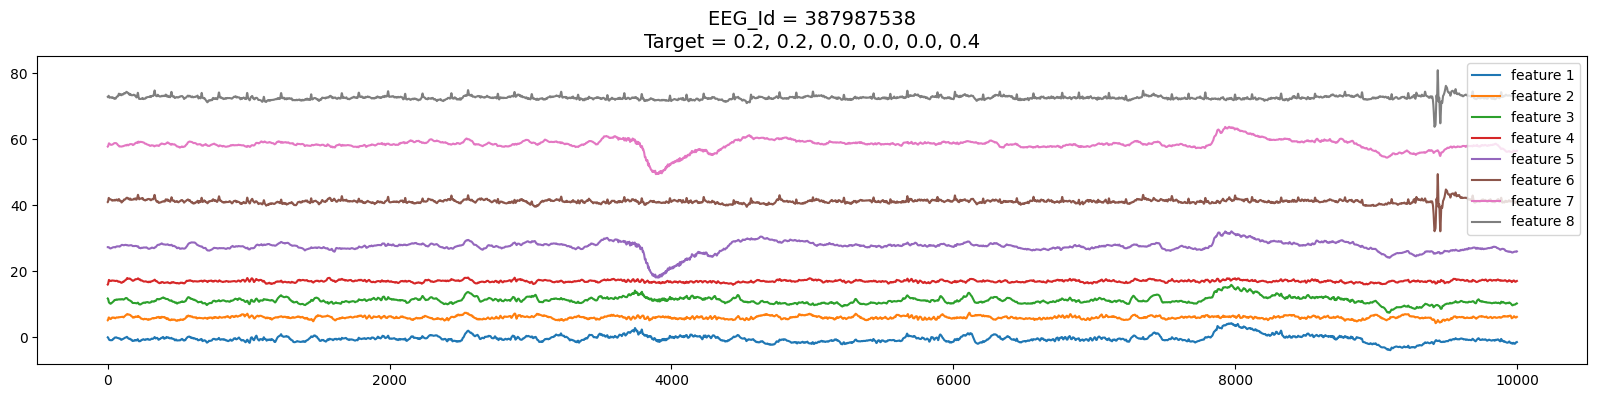

In [14]:
# CFG.visualize = True

for batch in train_loader:
    print('Hi')
    break
for batch in train_loader:
#         print('Hi')
    print(batch['eeg'])
    X = batch.pop("eeg")
    y = batch.pop("labels")
    for item in range(4):
        plt.figure(figsize=(20,4))
        offset = 0
        for col in range(X.shape[-1]):
            if col != 0:
                offset -= X[item,:,col].min()
            plt.plot(range(10000), X[item,:,col]+offset,label=f'feature {col+1}')
            offset += X[item,:,col].max()
        tt = f'{y[col][0]:0.1f}'
        for t in y[col][1:]:
            tt += f', {t:0.1f}'
        plt.title(f'EEG_Id = {eeg_ids[item]}\nTarget = {tt}',size=14)
        plt.legend()
        plt.show()
    break


In [49]:

class ResNet_1D_Block(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, downsampling, drop_prob):
        super(ResNet_1D_Block, self).__init__()
        self.bn1 = nn.BatchNorm1d(num_features=in_channels)
        self.relu = nn.ReLU(inplace=False)
        self.dropout = nn.Dropout(p=drop_prob, inplace=False)
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm1d(num_features=out_channels)
        self.conv2 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.downsampling = downsampling

    def forward(self, x):
        identity = x

        out = self.bn1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)

        out = self.maxpool(out)
        identity = self.downsampling(x)

        out += identity
        return out


class EEGNet(nn.Module):

    def __init__(self, kernels, in_channels=20, fixed_kernel_size=17, num_classes=6, drop_prob=.1):
        super(EEGNet, self).__init__()
        self.kernels = kernels
        self.planes = 24
        self.parallel_conv = nn.ModuleList()
        self.in_channels = in_channels
        
        for i, kernel_size in enumerate(list(self.kernels)):
            sep_conv = nn.Conv1d(in_channels=in_channels, out_channels=self.planes, kernel_size=(kernel_size),
                               stride=1, padding=0, bias=False,)
            self.parallel_conv.append(sep_conv)

        self.bn1 = nn.BatchNorm1d(num_features=self.planes)
        self.relu = nn.ReLU(inplace=False)
        self.conv1 = nn.Conv1d(in_channels=self.planes, out_channels=self.planes, kernel_size=fixed_kernel_size,
                               stride=2, padding=2, bias=False)
        self.block = self._make_resnet_layer(kernel_size=fixed_kernel_size, stride=1, padding=fixed_kernel_size//2, drop_prob=drop_prob)
        self.bn2 = nn.BatchNorm1d(num_features=self.planes)
        self.avgpool = nn.AvgPool1d(kernel_size=6, stride=6, padding=2)
        self.rnn = nn.GRU(input_size=self.in_channels, hidden_size=128, num_layers=1, bidirectional=True)
        self.fc = nn.Linear(in_features=424, out_features=num_classes)

    def _make_resnet_layer(self, kernel_size, stride, blocks=9, padding=0, drop_prob=.1):
        layers = []
        downsample = None
        base_width = self.planes

        for i in range(blocks):
            downsampling = nn.Sequential(
                    nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
                )
            layers.append(ResNet_1D_Block(in_channels=self.planes, out_channels=self.planes, kernel_size=kernel_size,
                                       stride=stride, padding=padding, downsampling=downsampling, drop_prob=drop_prob))

        return nn.Sequential(*layers)
    def extract_features(self, x):
        # x : B=64 x T=10_000 x C=8
        x = x.permute(0, 2, 1)      # -> B x C x T
        out_sep = []

        for i in range(len(self.kernels)):
            sep = self.parallel_conv[i](x)
            out_sep.append(sep)

        out = torch.cat(out_sep, dim=2)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv1(out)  

        out = self.block(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.avgpool(out)  
        
        out = out.reshape(out.shape[0], -1)  
        rnn_out, _ = self.rnn(x.permute(0, 2, 1))
        new_rnn_h = rnn_out[:, -1, :]  
        

        new_out = torch.cat([out, new_rnn_h], dim=1) 
        return new_out
    
    def forward(self, x, targets=None):
        new_out = self.extract_features(x)
        logits = self.fc(new_out)  
        
        loss = None
        if targets is not None:
            loss = CFG.criterion(F.log_softmax(logits, dim=1), targets)

        return logits, loss

In [77]:
import gc
iot = torch.randn(2, 10000, 8)#.cuda()
model = EEGNet(kernels=[3,5,7,9], in_channels=CFG.in_channels, fixed_kernel_size=5, num_classes=CFG.num_class, drop_prob=.2)
output, loss = model(iot)
print("{:.1f}M parameters".format(sum([p.numel() for p in model.parameters()])/1e6))
print(output.shape)

del iot, model
gc.collect()

0.2M parameters
torch.Size([2, 6])


0

In [78]:

@torch.no_grad()
def eval(model, data_loader, eval_iters=5):
    model.eval()
    lossi = []
    for step, batch in enumerate(data_loader):
        eeg, labels = batch['eeg'].to(device), batch['labels'].to(device)
        _, loss = model(eeg, labels)
        lossi.append(loss.item())
        if step > eval_iters:
            break
    return np.mean(lossi)


# A minimal training function
def train_loop(fold):

    train_folds = train[(train['fold'] != fold) & (train['total_evaluators'] >= 5)].reset_index(drop=True)
    valid_folds = train[(train['fold'] == fold)].reset_index(drop=True)

    train_dataset = EEGDataset(train_folds, CFG, mode="train")
    valid_dataset = EEGDataset(valid_folds, CFG, mode="train")

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    #==== MODEL ===
    model = EEGNet(kernels=[3,5,7,9], 
                   in_channels=CFG.in_channels, 
                   fixed_kernel_size=5, 
                   num_classes=CFG.num_class,
                   drop_prob=.2)
    model.to(device)
    model = nn.DataParallel(model)
    optim = torch.optim.AdamW(model.parameters())
    val_loss = 0.0

    for epoch in range(CFG.epochs):
        with tqdm(train_loader, unit='batch') as tepoch:
            for step, batch in enumerate(tepoch):
                tepoch.set_description(f"Epoch {epoch+1}")

                model.train()
                eeg, labels = batch['eeg'].to(device), batch['labels'].to(device)
                optim.zero_grad()
                logits, loss = model(eeg, labels)
                
                loss.backward()
                optim.step()

                # if step%CFG.eval_every == 0 or step==len(tepoch)-1:
                #     val_loss = eval(model, valid_dataset)
                tepoch.set_postfix(loss=loss.item())
                
        print(f"After epoch {epoch+1}, val loss : {eval(model, valid_loader, eval_iters=10):.2f}")
    
    torch.save(model.state_dict(), f"./models/ver{CFG.version}_fold{fold}.pt")




In [81]:
for fold in CFG.trn_fold:
    print(f"#========== Fold {fold} ==========")
    train_loop(fold)

#========== Fold 0 ==========


Epoch 1: 100%|██████████| 92/92 [01:22<00:00,  1.12batch/s, loss=0.547]


After epoch 1, val loss : 0.76


Epoch 2: 100%|██████████| 92/92 [01:13<00:00,  1.25batch/s, loss=0.399]


After epoch 2, val loss : 0.73


Epoch 3: 100%|██████████| 92/92 [01:15<00:00,  1.22batch/s, loss=0.402]


After epoch 3, val loss : 0.67


Epoch 4: 100%|██████████| 92/92 [01:10<00:00,  1.31batch/s, loss=0.414]


After epoch 4, val loss : 0.68


Epoch 5: 100%|██████████| 92/92 [01:06<00:00,  1.38batch/s, loss=0.37] 


After epoch 5, val loss : 0.68


Epoch 6: 100%|██████████| 92/92 [01:05<00:00,  1.41batch/s, loss=0.334]


After epoch 6, val loss : 0.61


Epoch 7: 100%|██████████| 92/92 [01:06<00:00,  1.38batch/s, loss=0.298]


After epoch 7, val loss : 0.67


Epoch 8: 100%|██████████| 92/92 [01:04<00:00,  1.43batch/s, loss=0.302]


After epoch 8, val loss : 0.62


Epoch 9: 100%|██████████| 92/92 [01:05<00:00,  1.40batch/s, loss=0.315]


After epoch 9, val loss : 0.63


Epoch 10: 100%|██████████| 92/92 [01:06<00:00,  1.38batch/s, loss=0.344]


After epoch 10, val loss : 0.65
#========== Fold 1 ==========


Epoch 1: 100%|██████████| 95/95 [01:13<00:00,  1.29batch/s, loss=0.63] 


After epoch 1, val loss : 0.74


Epoch 2: 100%|██████████| 95/95 [01:23<00:00,  1.14batch/s, loss=0.452]


After epoch 2, val loss : 0.78


Epoch 3: 100%|██████████| 95/95 [01:20<00:00,  1.18batch/s, loss=0.406]


After epoch 3, val loss : 0.73


Epoch 4: 100%|██████████| 95/95 [01:19<00:00,  1.20batch/s, loss=0.421]


After epoch 4, val loss : 0.67


Epoch 5: 100%|██████████| 95/95 [01:19<00:00,  1.19batch/s, loss=0.391]


After epoch 5, val loss : 0.75


Epoch 6: 100%|██████████| 95/95 [01:17<00:00,  1.22batch/s, loss=0.384]


After epoch 6, val loss : 0.77


Epoch 7: 100%|██████████| 95/95 [01:19<00:00,  1.20batch/s, loss=0.336]


After epoch 7, val loss : 0.62


Epoch 8:   5%|▌         | 5/95 [00:04<01:13,  1.22batch/s, loss=0.286]